Example usage of adjoint method used to optimize the initial velocity of the bullet in order to hit target location. 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import numpy.random as npr
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

## Definine initial condition for the velocity and position

In [4]:
num_steps = 1000

v0 = 10 * tf.to_float([1., 1.])  # initial velocity
r0 = tf.to_float([0., 0.])  # initial position

init_state = tf.concat([r0, v0], 0)
print(init_state.numpy())

[ 0.  0. 10. 10.]


Solving Newton dynamics for point with air drag [wikipedia](https://en.wikipedia.org/wiki/Drag_(physics):
$$
    \frac{d\mathbf{v}}{dt} = \mathbf{g} - k \mathbf{v}
$$
and second equation for position:
$$
    \frac{d\mathbf{r}}{dt} = \mathbf{v}
$$

In [5]:
class BulletODE(tf.keras.Model):
    def call(self, inputs, **kwargs):
        t, rv_vec = inputs
        # constants
        gamma = 2  # air drag
        g = - 10   # gravity
        
        r_vec, v_vec = rv_vec[:2], rv_vec[2:]
        # compute v**2
        v_length = tf.reduce_sum(v_vec**2) + 1e-6
        # compute versor vector
        vn = v_vec #/ v_length
        # some gravity
        g_vec = g * tf.to_float([0, 1])
        
        return tf.concat([v_vec,  g_vec - gamma * vn], 0)

In [6]:
from neural_ode import NeuralODE, defun_neural_ode

In [7]:
neural_ode = NeuralODE(BulletODE(), t=np.linspace(0., 1.5, 100))
target_state, states_history = neural_ode.forward(init_state, return_states="numpy")

In [8]:
trajectory = np.stack(states_history)
trajectory.shape

(100, 4)

In [44]:
def plot_trajectory(trajectories, labels):
    for trajectory, label in zip(trajectories, labels):
        plt.plot(*trajectory[:, :2].T, label=label)
        
    n = trajectory.shape[0]
    plt.plot(np.linspace(0, 5, n), np.zeros(n), 'k-')
    plt.plot(2, 0, 'rx', label='target', lw=20)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.legend()

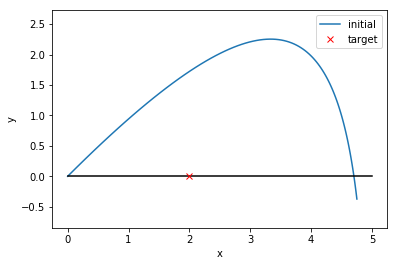

In [45]:
plot_trajectory([trajectory], ["initial"])

## Set new target hit location at r = (2, 0)

In [11]:
v0 = tf.to_float([0., 0.])
r0 = tf.to_float([2., 0.])
target_state = tf.concat([r0, v0], 0)

In [12]:
opt_neural_ode = NeuralODE(BulletODE(), t=np.linspace(0., 1.5, 100))
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.02, momentum=0.9)

## Set initial conditions for position and velocity

In [13]:
start_state = tf.Variable(init_state.numpy(), name="start_state")
start_state

<tf.Variable 'start_state:0' shape=(4,) dtype=float32, numpy=array([ 0.,  0., 10., 10.], dtype=float32)>

In [14]:
# convert eager graph to static
opt_neural_ode_defun = defun_neural_ode(opt_neural_ode)

## Solve problem with direct backpropagation through graph
This uses tensorflow graph in order to optimize initial condition

In [15]:
loss_history = []
for step in tqdm(range(100)):
    with tf.GradientTape() as g:    
        g.watch(start_state) 
        # integrate
        end_state = opt_neural_ode_defun.forward(start_state)
        # compute loss
        loss = tf.reduce_sum(tf.square(end_state[:2] - target_state[:2]))        
        
    dLoss = g.gradient(loss, start_state) 
    # we are interested only in velocity 
    dLoss = tf.to_float([0, 0, dLoss[2], dLoss[3]])    
    optimizer.apply_gradients([(dLoss, start_state)])
    loss_history.append(loss) 

100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


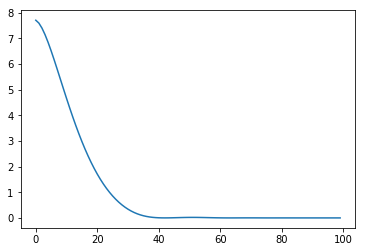

In [16]:
plt.plot(loss_history)

In [17]:
opt_target_state, opt_states_history = neural_ode.forward(start_state, return_states="numpy")
opt_trajectory = np.stack(opt_states_history)

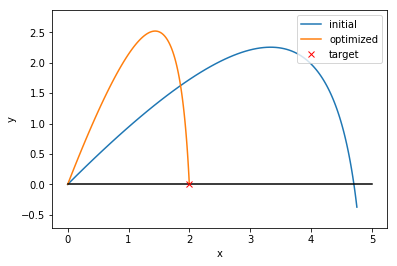

In [46]:
plot_trajectory([trajectory, opt_trajectory], ["initial", "optimized"])

## Solve problem with adjoint method

In [19]:
opt_neural_ode = NeuralODE(BulletODE(), t=np.linspace(0., 1.5, 100))
opt_neural_ode_defun = defun_neural_ode(opt_neural_ode)

In [23]:
start_state = tf.Variable(init_state, name="start_state")
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.02, momentum=0.9)

In [24]:
loss_history = []
for step in tqdm(range(100)):
    # integrate dynamics
    end_state = opt_neural_ode_defun.forward(start_state)
    with tf.GradientTape() as g:            
        # compute simple L2 loss between final position and target
        g.watch(end_state)
        end_position = end_state[:2]
        target_position = target_state[:2]
        loss = tf.reduce_sum(tf.square(end_position - target_position))
    # compute gradient
    dLoss = g.gradient(loss, end_state)
    
    # compute dynamics in backward manner using adjoint method:
    h_start, dfdh0, dWeights = opt_neural_ode_defun.backward(end_state, dLoss)
    # apply gradients for velocity
    dLoss = tf.to_float([0.0, 0.0, dfdh0[2], dfdh0[3]])
    optimizer.apply_gradients([(dLoss, start_state)])
    loss_history.append(loss)

100%|██████████| 100/100 [00:13<00:00,  7.60it/s]


In [26]:
opt_neural_ode = NeuralODE(BulletODE(), t=np.linspace(0., 1.5, 100))
_, opt_adjoint_states_history = opt_neural_ode.forward(start_state, return_states="numpy")
opt_adjoint_trajectory = np.stack(opt_adjoint_states_history)

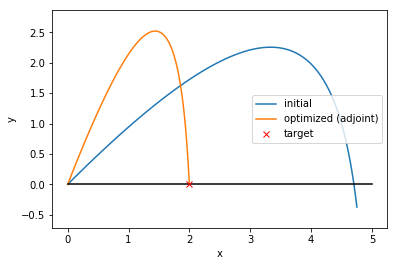

In [47]:
plot_trajectory([trajectory, opt_adjoint_trajectory], ["initial", "optimized (adjoint)"])